In [ ]:
!pip install tensorflow keras numpy pandas matplotlib opencv-python scikit-learn pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.2 MB/s eta 0:00:00


In [ ]:
# import neccessary packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras

import numpy as np
import sklearn
import cv2
import os
import time
import seaborn as sns
import pickle

## ---------------
sns.set()
# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]
## ---------------

In [ ]:
!pip install kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()  # Select the downloaded `kaggle.json` file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raurshithareddy","key":"f7f8c4371a7cca872b74446490bc93f0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Set permissions

In [ ]:
# Verify the downloaded file name
!ls

sample_data


In [ ]:
# List datasets to confirm it's working
!kaggle datasets list -s "nih chest x-ray"
# Replace with your actual dataset name
!kaggle datasets download -d nih-chest-xrays/sample
# Unzip it
!unzip sample.zip -d sample_chest_xray_data

Streaming output truncated to the last 5000 lines.
  inflating: sample_chest_xray_data/sample/sample/images/00003129_000.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_001.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_004.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_009.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003129_011.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003135_000.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003140_007.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003159_001.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003169_001.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003177_002.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003186_004.png  
  inflating: sample_chest_xray_data/sample/sample/images/00003186_005.png  
  inflating: sample_chest_xray_data/s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

**Data Exploration**

In [ ]:
# Load the metadata CSV
csv_path = ('sample_chest_xray_data/sample/sample_labels.csv')
df = pd.read_csv(csv_path)

In [ ]:
# Preview basic info
print("Initial Dataset Shape:", df.shape)
print(df.head())
print(df.info())

Initial Dataset Shape: (5606, 11)
        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                30

In [ ]:
# Step 1: Clean Data
# Convert age to numeric
df['Patient Age'] = pd.to_numeric(df['Patient Age'], errors='coerce')
# Fill missing age values with median
df['Patient Age'] = df['Patient Age'].fillna(df['Patient Age'].median())


In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,NaN,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,NaN,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,NaN,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,NaN,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,NaN,F,AP,2500,2048,0.168,0.168


In [ ]:
# Clean and encode Gender
df['Patient Gender'] = df['Patient Gender'].fillna('UNKNOWN')
df['Gender_Encoded'] = df['Patient Gender'].map({'M': 1, 'F': 0, 'UNKNOWN': -1})

# Fill missing View Position
df['View Position'] = df['View Position'].fillna('UNKNOWN')

# Encode View Position
df['View_Encoded'] = df['View Position'].astype('category').cat.codes

In [ ]:
# Convert 'Finding Labels' to list
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# Binary column: Normal = 'No Finding' only
df['Is_Normal'] = df['Finding Labels'].apply(lambda x: 1 if x == ['No Finding'] else 0)

# Multi-label binarization: extract unique diseases
all_labels = [label for sublist in df['Finding Labels'] for label in sublist if label != 'No Finding']
unique_diseases = sorted(set(all_labels))

# Create binary columns for each disease
for disease in unique_diseases:
    df[disease] = df['Finding Labels'].apply(lambda labels: int(disease in labels))

In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,"[Emphysema, Infiltration, Pleural_Thickening, ...",5,13,NaN,M,AP,3056,2544,0.139,...,0,1,0,0,1,0,0,1,0,1
1,00000013_026.png,"[Cardiomegaly, Emphysema]",26,13,NaN,M,AP,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
2,00000017_001.png,[No Finding],1,17,NaN,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000030_001.png,[Atelectasis],1,30,NaN,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,"[Cardiomegaly, Edema, Effusion]",1,32,NaN,F,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0


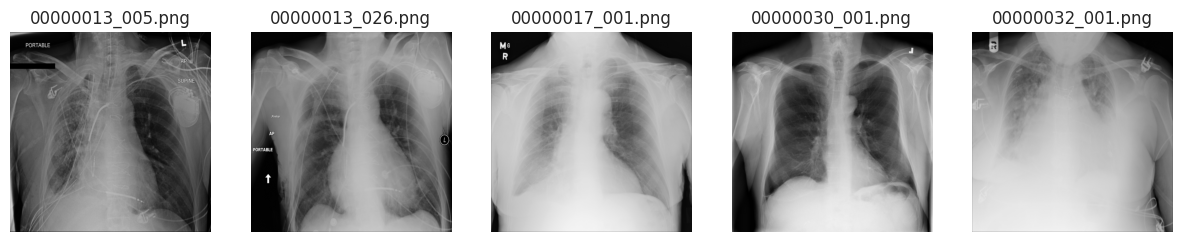

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_dir = '/content/sample_chest_xray_data/sample/sample/images'

# Get all image filenames
image_files = sorted(os.listdir(image_dir))[:5]  # First 5 images

# Plot images
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_dir, img_file)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(img_file)
    plt.axis('off')
plt.show()

**Investigate a single image**

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.3671 and the standard deviation is 0.1762


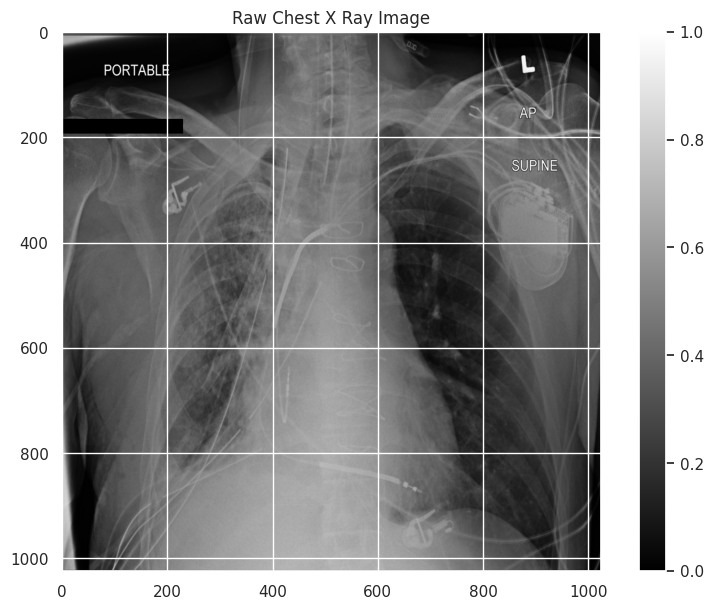

In [ ]:
# Get the first image that was listed in the train_df dataframe
#sample_img = train_df.Image[0]
# Corrected: Use an actual image filename from the list of image files
sample_img_filename = image_files[0] # Assuming image_files is available from the previous cell
raw_image = plt.imread(os.path.join(image_dir, sample_img_filename))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

**Investigate pixel value distribution**

Plot up the distribution of pixel values in the image shown above.

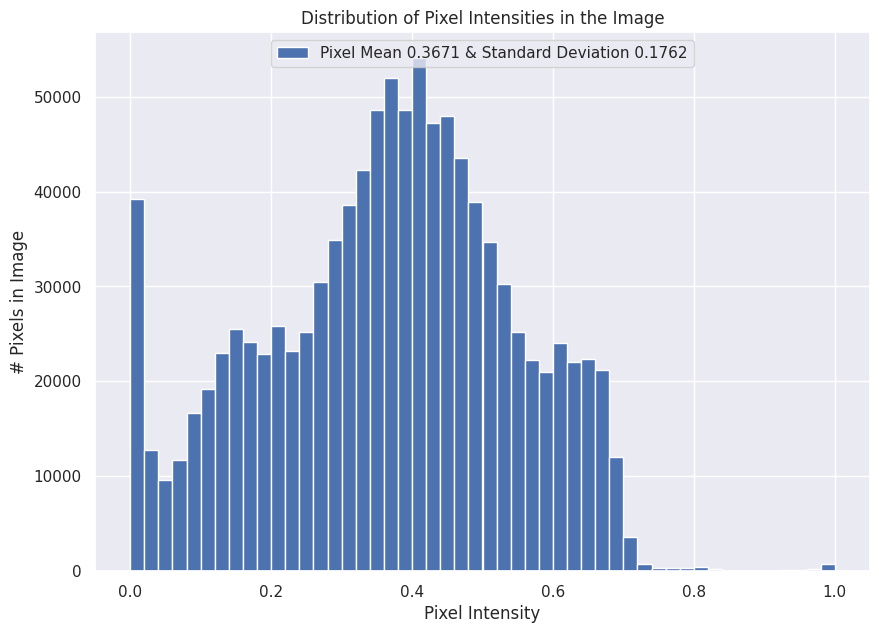

In [ ]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

In [ ]:
# Step 2: Class Distribution Analysis
# Total normal vs abnormal
print("\nNormal vs Abnormal Case Counts:")
print(df['Is_Normal'].value_counts())


Normal vs Abnormal Case Counts:
Is_Normal
1    3044
0    2562
Name: count, dtype: int64


In [ ]:
# Frequency of each disease
disease_counts = df[unique_diseases].sum().sort_values(ascending=False)
print("\nDisease Counts:\n", disease_counts)


Disease Counts:
 Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Pleural_Thickening    176
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
dtype: int64


/tmp/ipython-input-212597321.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='magma')


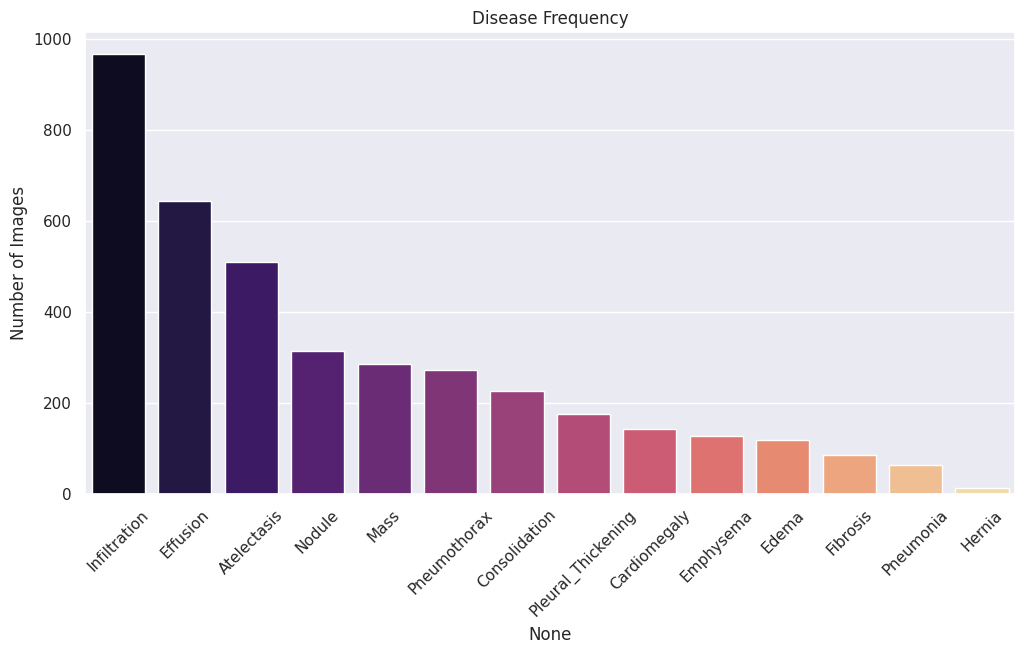

In [ ]:
# Plot class distribution
plt.figure(figsize=(12,6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='magma')
plt.xticks(rotation=45)
plt.title("Disease Frequency")
plt.ylabel("Number of Images")
plt.show()


Multi-Label Distribution:
Num_Labels
1    4626
2     690
3     212
4      58
5      17
6       2
7       1
Name: count, dtype: int64


/tmp/ipython-input-3960265622.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values, palette='coolwarm')


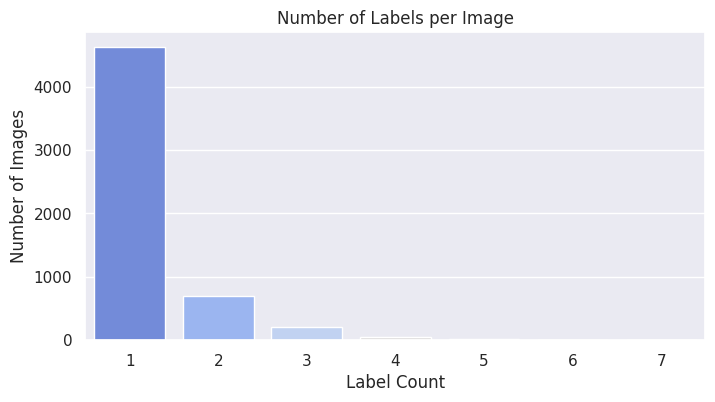

In [ ]:
# Multi-label frequency (number of labels per image)
df['Num_Labels'] = df['Finding Labels'].apply(len)
multi_label_counts = df['Num_Labels'].value_counts().sort_index()
print("\nMulti-Label Distribution:")
print(multi_label_counts)

plt.figure(figsize=(8,4))
sns.barplot(x=multi_label_counts.index, y=multi_label_counts.values, palette='coolwarm')
plt.title("Number of Labels per Image")
plt.xlabel("Label Count")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# Step 3: Prepare for Image Loading
# Add full image paths (assuming a structure)
df['Image Path'] = df['Image Index'].apply(lambda x: os.path.join('/content/sample_chest_xray_data/sample/sample/images'
, x))

# Example check (modify path if different)
print("\nSample Image Paths:")
print(df['Image Path'].head())


Sample Image Paths:
0    /content/sample_chest_xray_data/sample/sample/...
1    /content/sample_chest_xray_data/sample/sample/...
2    /content/sample_chest_xray_data/sample/sample/...
3    /content/sample_chest_xray_data/sample/sample/...
4    /content/sample_chest_xray_data/sample/sample/...
Name: Image Path, dtype: object


In [ ]:
# Step 4: Dataset Overview and Splitting
# -------------------------------------------------------------

# Final columns
print("\nCleaned DataFrame Columns:\n", df.columns.tolist())

# Save cleaned data
cleaned_csv_path = '/content/sample_chest_xray_data/cleaned_metadata.csv'
df.to_csv(cleaned_csv_path, index=False)
print("\nCleaned metadata saved to:", cleaned_csv_path)


Cleaned DataFrame Columns:
 ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y', 'Gender_Encoded', 'View_Encoded', 'Is_Normal', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Num_Labels', 'Image Path']

Cleaned metadata saved to: /content/sample_chest_xray_data/cleaned_metadata.csv


**Dataset Preparation and Augmentation**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import RandomErasing, RandAugment
from PIL import Image
import torch

# 1. Load + multi-hot encode
df = pd.read_csv('/content/sample_chest_xray_data/cleaned_metadata.csv')

label_columns = [
    col for col in df.columns
    if col not in [
        'Image Index','Finding Labels','Follow-up #','Patient ID',
        'Patient Age','Patient Gender','View Position',
        'OriginalImageWidth','OriginalImageHeight',
        'OriginalImagePixelSpacing_x','OriginalImagePixelSpacing_y',
        'Gender_Encoded','View_Encoded','Is_Normal',
        'Num_Labels','Image Path'
    ]
]
df['labels_vector'] = df[label_columns].values.tolist()

# 2. Split into train / val / test
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['Is_Normal'],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['Is_Normal'],
    random_state=42
)

print("\nDataset Split Sizes:")
print("  Train:", train_df.shape)
print("  Val:  ", val_df.shape)
print("  Test: ", test_df.shape)


# 3. Define your transforms
train_tf = transforms.Compose([
    transforms.Resize((320, 320)),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]),
    RandomErasing(p=0.3, scale=(0.02,0.1))
])

val_tf = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])


# 4. Create a custom Dataset
class ChestXrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row['Image Path']).convert('L')  # grayscale
        if self.transform:
            img = self.transform(img)
        labels = torch.tensor(row['labels_vector'], dtype=torch.float32)
        return img, labels


# 5. Instantiate datasets
train_ds = ChestXrayDataset(train_df, transform=train_tf)
val_ds   = ChestXrayDataset(val_df,   transform=val_tf)
test_ds  = ChestXrayDataset(test_df,  transform=val_tf)


# 6. (Optional) Build a WeightedRandomSampler for imbalanced training
#    Here, we balance on the binary 'Is_Normal' column:
class_counts   = train_df['Is_Normal'].value_counts().to_dict()
class_weights  = {k: 1.0/v for k, v in class_counts.items()}
sample_weights = train_df['Is_Normal'].map(class_weights).values
sampler        = WeightedRandomSampler(sample_weights, len(sample_weights))


# 7. Create DataLoaders (your “generators”)
batch_size = 16

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,        # sampler for class-balancing
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


# 8. Quick sanity check
imgs, labs = next(iter(train_loader))
print("Batch images:", imgs.shape)
print("Batch labels:", labs.shape)


Dataset Split Sizes:
  Train: (3924, 31)
  Val:   (841, 31)
  Test:  (841, 31)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch images: torch.Size([16, 1, 320, 320])
Batch labels: torch.Size([16, 14])


**Image Preprocessing in Keras**

**Standardization**

Normalizing images is better suited for trained a convolutional neural network. For this task we use the Keras  ImageDataGenerator function to perform data preprocessing and data augumentation. The image_generator will adjust image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.


Create an image generator for preprocessing. Pre-process the data using the image_generatoras well as reduce the image size down to 320x320 pixels.

In [ ]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Define Labels and Paths**

In [ ]:
# Your 14 pathology labels
labels = [
    'Cardiomegaly','Emphysema','Effusion','Hernia','Infiltration',
    'Mass','Nodule','Atelectasis','Pneumothorax','Pleural_Thickening',
    'Pneumonia','Fibrosis','Edema','Consolidation'
]

# Directory where your resized 320×320 chest X-rays live
IMAGE_DIR = "/content/sample_chest_xray_data/sample/sample/images"

**Training Generator: Augmentation + Feature-Wise Normalization**

Fit the generator on a small sample to compute global mean/std. Augment and normalize every batch.

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 224, target_h = 224):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """
    print("getting train generator...")
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,

        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation

    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8,
                                 seed=1, target_w = 224, target_h = 224):
    """
    Return generator for validation set and test test set using
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h), # Corrected indentation
        color_mode="grayscale" # Corrected indentation
    )

    # get data sample
    batch = raw_train_generator.next() # generate a batch of samples and associated labels
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)

    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h),
            color_mode="grayscale" ) # by default rgb

    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h),
            color_mode="grayscale" ) # by default rgb
    return valid_generator, test_generator

getting train generator...
Found 3924 validated image filenames.


IndexError: index 8 is out of bounds for axis 0 with size 8

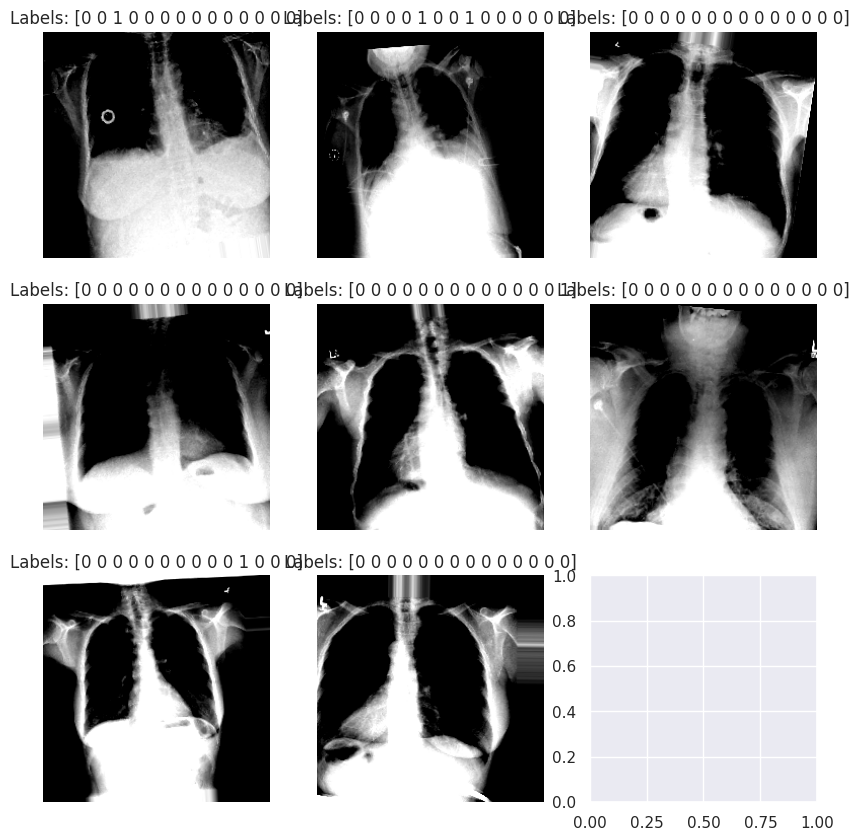

In [ ]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Path", labels)

images, labels = next(train_generator)
# Plot the images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # .squeeze() to remove the extra channel dimension if grayscale
    plt.title(f"Labels: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

The dimensions of the image are 224 pixels width and 224 pixels height
The maximum pixel value is 2.0758 and the minimum is -2.9856
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


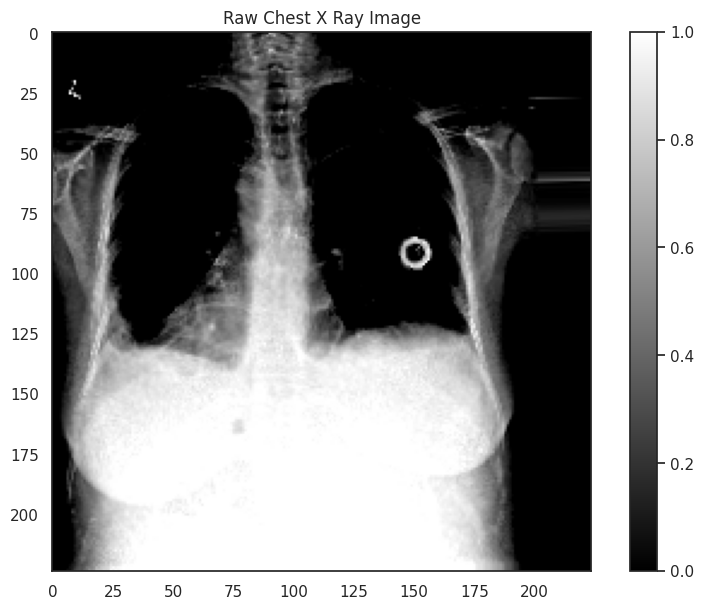

In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

**If the above doesn't work, then you have to re-run before 3 cells from data splitting.**

In [ ]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 224, 224, 3) (224, 224, 3)
(1024, 1024)


**To check whether the preprocessing normalize the data correctly. And verifying whether the model seeing consistent, centered input images.**

/tmp/ipython-input-2816129532.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
/tmp/ipython-input-2816129532.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


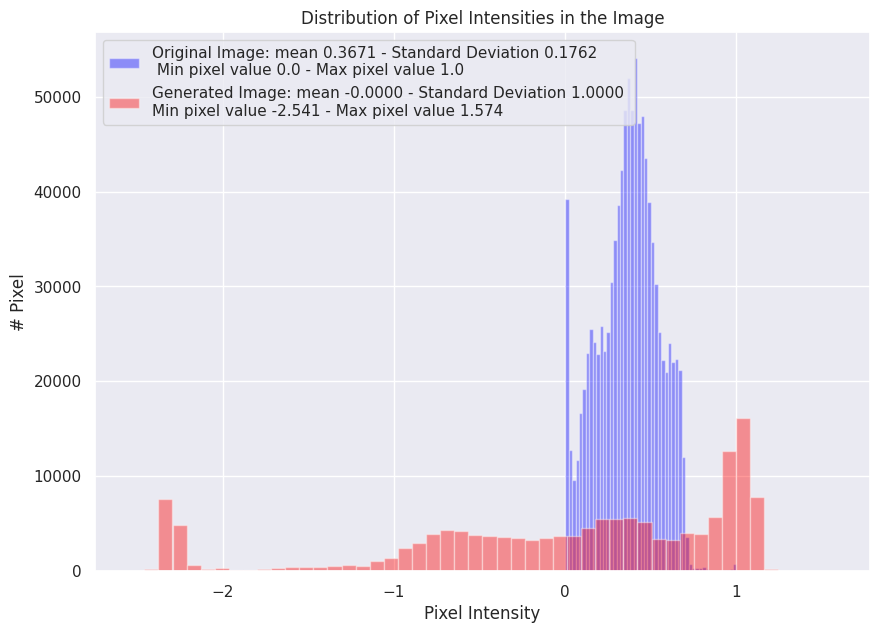

In [ ]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(),
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue',
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(),
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}',
             color='red',
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

**Addressing Class Imbalance**

The major challenge when it comes to deal with medical diagnostic datasets is large class imbalance in such datasets.

In [ ]:
label_counts = df['Finding Labels'].value_counts()
print(label_counts)

Finding Labels
['No Finding']                                          3044
['Infiltration']                                         503
['Effusion']                                             203
['Atelectasis']                                          192
['Nodule']                                               144
                                                        ... 
['Cardiomegaly', 'Consolidation', 'Infiltration']          1
['Emphysema', 'Pleural_Thickening', 'Pneumothorax']        1
['Atelectasis', 'Consolidation', 'Effusion', 'Mass']       1
['Consolidation', 'Effusion', 'Pneumonia']                 1
['Cardiomegaly', 'Effusion', 'Emphysema']                  1
Name: count, Length: 244, dtype: int64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# labels: list of class names in the order used in your label matrix
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
          'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
          'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

# train_generator.labels: shape = (num_samples, num_classes)
# Compute mean (frequency) across axis=0
frequencies = np.mean(train_generator.labels, axis=0)



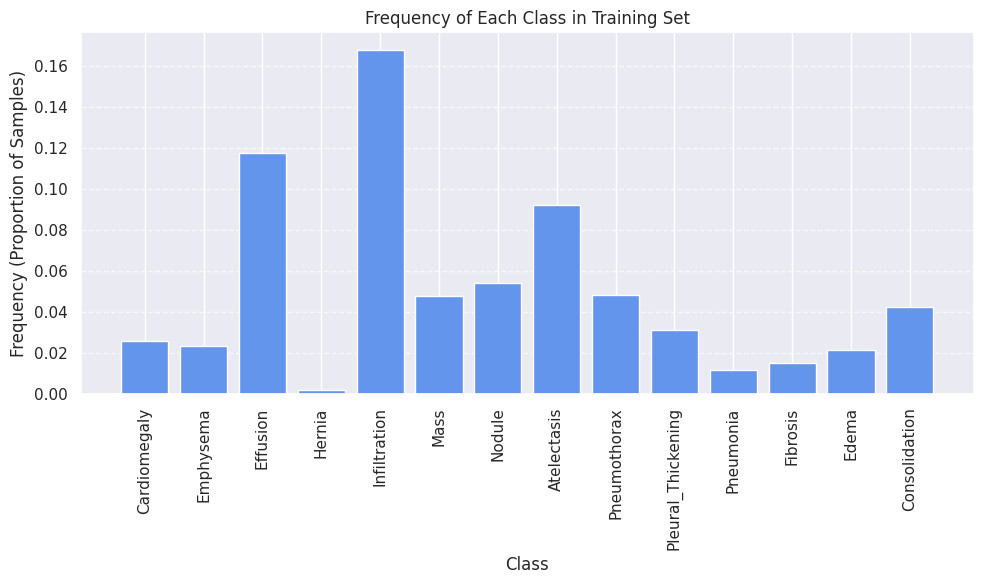

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(x=labels, height=frequencies, color='cornflowerblue')
plt.xticks(rotation=90)
plt.title("Frequency of Each Class in Training Set")
plt.xlabel("Class")
plt.ylabel("Frequency (Proportion of Samples)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The chart illustrates the distribution of labels across the training set for the multi-label chest X-ray dataset. A significant class imbalance is observed, where certain disease categories appear far more frequently than others.



*   **Infiltration** is the most frequent label, present in over **16%** of the sample.
*   Other common labels include Efusion and Atelectasis, each representing a substantial proportion of the dataset.

* **Hernia** is severely underrepresented, with near-zero occurrence.
* Additional minority classes include Pneumonia, Fibrosis, Edema, and Cardiomegaly, all appearing in less than 2% of samples.

**Implications of Class Imbalance:**

* Model Bias Risk: The model is at risk of learning biased representations, favoring more frequent classes while underperforming on rare ones.

* Misleading Accuracy: Overall accuracy may be inflated by the model’s ability to predict dominant classes, masking poor performance on minority conditions.

* Generalization Limitation: Rare classes might be inadequately learned, reducing the model's ability to generalize across all disease types.

**Methods to Address Imbalance:**

* Apply Class-Weighted Loss Functions:
Use loss functions such as Binary Cross-Entropy with Logits or Focal Loss with class weights to emphasize rare classes during training.

* Data Augmentation for Minority Classes:
Generate synthetic variations of underrepresented samples to enhance diversity and balance.

* Sampling Strategies:
Implement oversampling of minority classes or undersampling of majority classes to improve balance during training.

* Robust Evaluation Metrics:
Employ metrics such as:

    1. **Per-class F1 Score**
    2. **Macro-averaged Precision/Recall**
    3. **Per-class AUC**

These metrics provide a more reliable assessment of model performance across all classes.



**Computing Class Frequencies**

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequencies for each class.

    Args:
        labels (np.array): binary label matrix (num_samples x num_classes)

    Returns:
        positive_frequencies (np.array)
        negative_frequencies (np.array)
    """
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = (N - np.sum(labels, axis=0)) / N
    return positive_frequencies, negative_frequencies


In [ ]:
# labels = train_generator.class_indices  # class names - Remove this line
# labels = list(labels.keys())  # convert dict to list of label names - Remove this line

# Assume 'labels' list is already defined in a previous cell
# Compute frequencies
freq_pos, freq_neg = compute_class_freqs(np.array(train_generator.labels))
print(freq_pos)

[0.02599388 0.02344546 0.11748216 0.00203874 0.16794088 0.04765545
 0.05428135 0.0922528  0.04816514 0.03109072 0.01172273 0.01529052
 0.02140673 0.04230377]


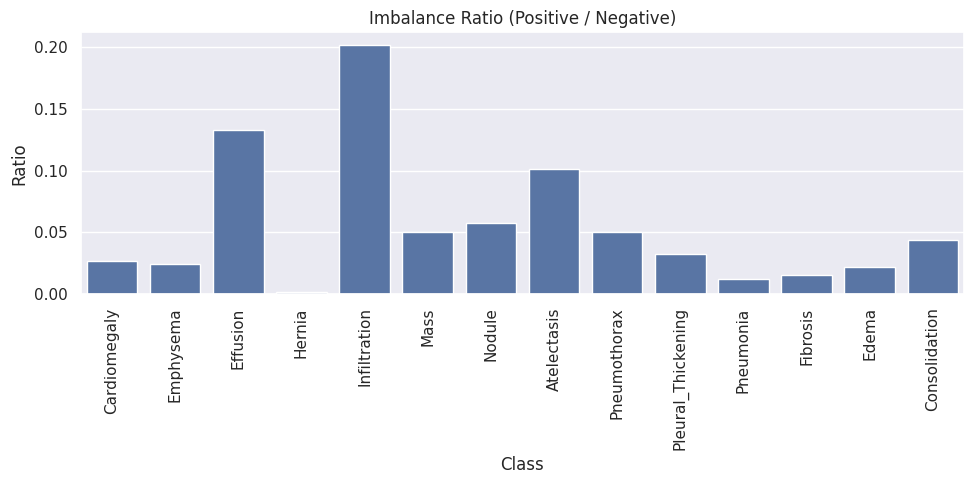

In [ ]:
imbalance_ratio = freq_pos / (freq_neg + 1e-5)
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=imbalance_ratio)
plt.title("Imbalance Ratio (Positive / Negative)")
plt.xticks(rotation=90)
plt.ylabel("Ratio")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


**Identifying class imbalance:**

* If some classes ocuur far less than others, the model might ignore them.

* The pos_weights and neg_weights are useful when passing weights to loss functions (like BinaryCrossentropy).

The bar plots illstruate to review the imbalance rather than just numbers.

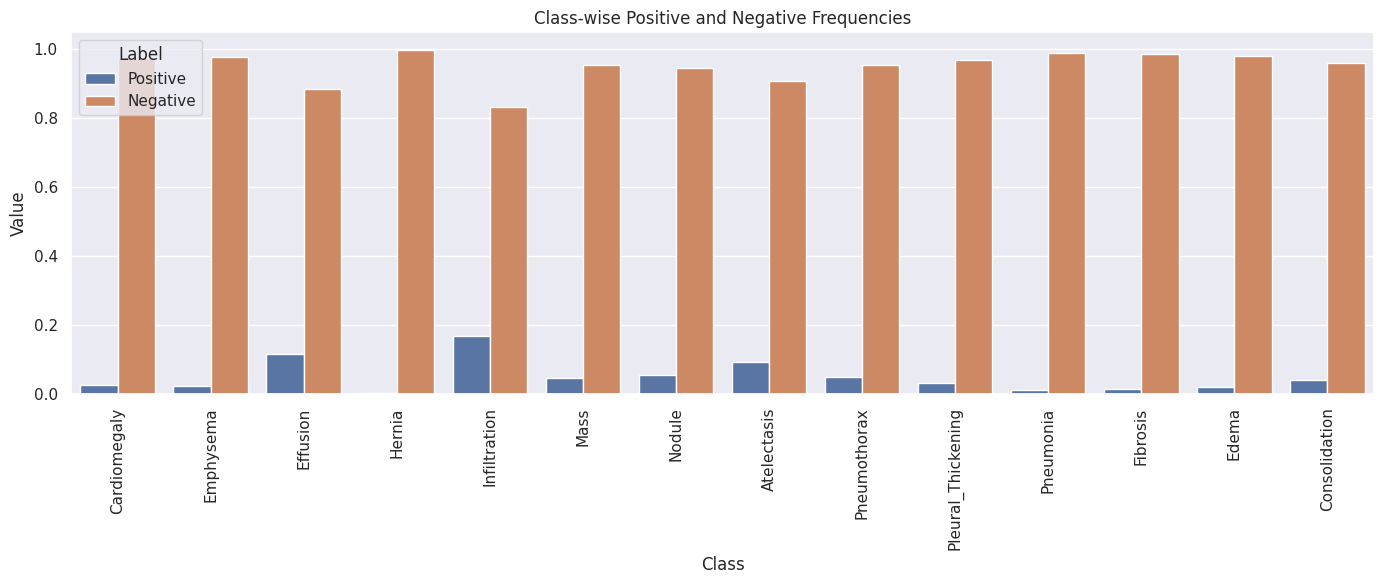

In [ ]:
# Create a DataFrame for seaborn for positive frequencies
data = pd.DataFrame({
    "Class": labels,
    "Label": "Positive",
    "Value": freq_pos # Assuming freq_pos is defined in a previous cell
})

# Create a DataFrame for negative frequencies
negative_data = pd.DataFrame({
    "Class": labels,
    "Label": "Negative",
    "Value": freq_neg # Assuming freq_neg is defined in a previous cell
})

# Concatenate the two DataFrames
data = pd.concat([data, negative_data], ignore_index=True) # Corrected to use pd.concat

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.xticks(rotation=90)
plt.title("Class-wise Positive and Negative Frequencies")
plt.tight_layout()
plt.show()

* All classes are highly imbalanced, with far more negative samples than positive ones.
* This especially true for **Emphysemma, Pneumothorax, Fibrosis**, and **Edema** - the positive frequency is barely visible, indicating very few positive samples.

* **Infiltration, Atelectasis**, and **Effusion** have **comparatively higher **positive frequencies than other classes.
* These may be the more common pathologies in your dataset and could dominate learning if weights are not used.


* **Hernia, Fibrosis**, and **Pneumothorax** show **extremely** **low** positive frequencies.

  These rare conditions may be underrepresented in training unless:

   * Data augmentation, oversampling, or loss weighting is applied.

**Need for Weighted Loss or Balanced Sampling:**

The imbalance seen in this plot justifies the need for:

    1. Class-weighted loss functions

    2. Data balancing strategies (e.g., over/under-sampling, augmentation)

    3. Otherwise, the model may simply learn to predict negatives across most classes.

**Compute Weighted Contributions**

In [ ]:
# Assign pos/neg weights (inversely proportional to frequency)
pos_weights = freq_neg
neg_weights = freq_pos

# Contribution from positive and negative examples
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights


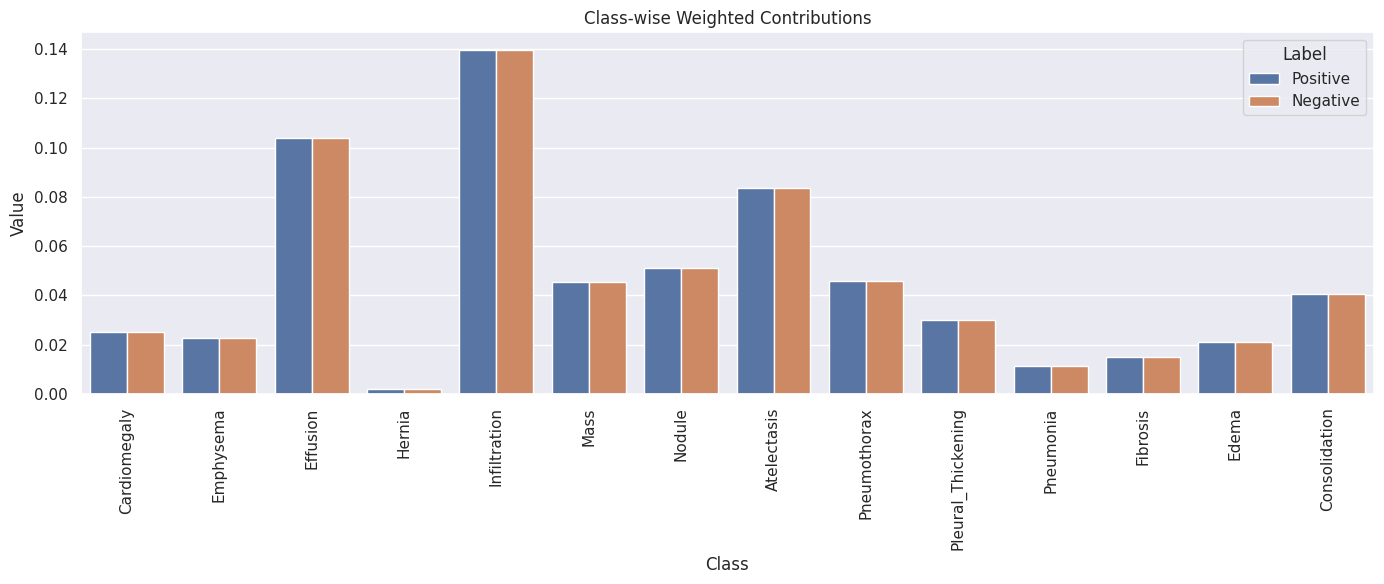

In [ ]:
import pandas as pd # Added import for pandas
import matplotlib.pyplot as plt # Added import for matplotlib.pyplot
import seaborn as sns # Added import for seaborn
import numpy as np # Added import for numpy

data_contrib = pd.DataFrame({
    "Class": labels,
    "Label": "Positive",
    "Value": pos_contribution # Assuming pos_contribution is defined
})

# Create a DataFrame for negative contributions
negative_data_contrib = pd.DataFrame({
    "Class": labels,
    "Label": "Negative",
    "Value": neg_contribution # Assuming neg_contribution is defined
})

# Concatenate the two DataFrames
data_contrib = pd.concat([data_contrib, negative_data_contrib], ignore_index=True) # Corrected to use pd.concat


# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x="Class", y="Value", hue="Label", data=data_contrib)
plt.xticks(rotation=90)
plt.title("Class-wise Weighted Contributions")
plt.tight_layout()
plt.show()

**Use Weights in Weighted Loss Function**

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

#def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
 #   pos_weights = tf.convert_to_tensor(pos_weights, dtype=tf.float32)
  #  neg_weights = tf.convert_to_tensor(neg_weights, dtype=tf.float32)

   # def weighted_loss(y_true, y_pred):
    #    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)  # avoid log(0)

        # Compute per-label losses
     #   loss = - pos_weights * K.mean(y_true * K.log(y_pred), axis=0) \
      #         - neg_weights * K.mean((1 - y_true) * K.log(1 - y_pred), axis=0)

       # return K.sum(loss)  # Sum over all labels
    #return weighted_loss


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += - pos_weights.iloc[i] * K.mean(y_true[:, i] * K.log(y_pred[:, i] + epsilon)) \
                    - neg_weights.iloc[i] * K.mean((1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
        return loss
    return weighted_loss

# Use it like this during model compilation:
#model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])


**DenseNet121**

Previous Model

In [ ]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():

    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights='imagenet', include_top=False) # Corrected weights argument
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #-------------
    #x = Dense(512, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #x = BatchNormalization()(x)
    #x = Dense(256, activation='relu')(x)
    #x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)

    # and a logistic layer
    predictions = Dense(len(labels), activation='sigmoid')(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    # ----
    model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])

    # model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    # model.load_weights("nih_new/pretrained_model.h5") # Commented out loading specific weights for now
    print("Loaded Weights") # This print statement is now slightly misleading, but keeping for consistency

    return model

In [ ]:
model = load_C3M3_model()

Got loss weights
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


Let's observe the layers that model is composed of.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# print out the total number of layers
layers_ = model.layers
print('total number of layers =', len(layers_))

total number of layers = 429


In [ ]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers
                if str(type(layer)).find('Conv2D') > -1]

In [ ]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('conv5_block16_concat').output)
print('Model output ------------->', model.output)

Model input --------------> <KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>
Feature extractor output -> <KerasTensor shape=(None, None, None, 1024), dtype=float32, sparse=False, ragged=False, name=keras_tensor_424>
Model output -------------> <KerasTensor shape=(None, 14), dtype=float32, sparse=False, ragged=False, name=keras_tensor_428>


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validation data generator
val_datagen = ImageDataGenerator(rescale=1./255) # You might want to use the same normalization as the train generator

valid_generator = val_datagen.flow_from_dataframe( # Changed from flow_from_directory
    dataframe=val_df, # Added dataframe argument
    directory=IMAGE_DIR,  # Use your image directory
    x_col='Image Index', # Use the column with image filenames
    y_col=labels, # Use the list of label columns
    target_size=(320, 320),     # Replace with your input size - Using 320x320 as per generators in LNYlzI1Zh1WF
    batch_size=32,
    class_mode='raw',   # for multi-label classification
    shuffle=False
)

Found 841 validated image filenames.


**Model Training**

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy # Added import

#from keras.optimizers import Adam
#optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(threshold=0.5)])

#history = model.fit(train_generator,
 #                   validation_data=valid_generator,
 #                   steps_per_epoch=10,         # just to check progress
 #                   validation_steps=2,
 #                   epochs=3)

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(valid_generator),
                    epochs=10)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 582s 830ms/step - binary_accuracy: 0.9502 - loss: 0.1808 - val_binary_accuracy: 0.9336 - val_loss: 0.3821
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 132s 268ms/step - binary_accuracy: 0.9493 - loss: 0.1825 - val_binary_accuracy: 0.6352 - val_loss: 10.6175
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 137s 279ms/step - binary_accuracy: 0.9498 - loss: 0.1816 - val_binary_accuracy: 0.6519 - val_loss: 2.5713
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 138s 271ms/step - binary_accuracy: 0.9498 - loss: 0.1792 - val_binary_accuracy: 0.1902 - val_loss: 994.8658
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 143s 273ms/step - binary_accuracy: 0.9502 - loss: 0.1808 - val_binary_accuracy: 0.7092 - val_loss: 2.7023
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 132s 270ms/step - binary_accuracy: 0.9500 - loss: 0.1804 - val_binary_accuracy: 0.8220 - val_loss: 0.6099
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 141s 267ms/step - binary_accuracy: 0.9505 - loss: 0.1782 - val_binary_accuracy: 0

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(valid_generator),
                    epochs=10)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2970s 6s/step - binary_accuracy: 0.9340 - loss: 0.2120 - val_binary_accuracy: 0.9502 - val_loss: 0.1835
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2953s 6s/step - binary_accuracy: 0.9479 - loss: 0.1925 - val_binary_accuracy: 0.9502 - val_loss: 0.1898
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 2939s 6s/step - binary_accuracy: 0.9518 - loss: 0.1789 - val_binary_accuracy: 0.9502 - val_loss: 0.1827
Epoch 4/10
 24/491 ━━━━━━━━━━━━━━━━━━━━ 41:52 5s/step - binary_accuracy: 0.9566 - loss: 0.1627

In [ ]:
x_batch, y_batch = next(iter(train_generator))
preds = model.predict(x_batch)

print("True Labels:", y_batch[5])
print("Predicted :", preds[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
True Labels: [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Predicted : [0.00863794 0.02196896 0.03565162 0.00398523 0.10095009 0.02111885
 0.05429899 0.03248012 0.03380835 0.0164285  0.00450424 0.02074491
 0.00120531 0.01118321]


**If you want to save the history object for loss/accuracy plots later.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ✅ Save the entire model using the new .keras format
model.save('/content/drive/MyDrive/nih_chest_xray_model.keras')

# ✅ Save the training history (no change needed)
import pickle
with open('/content/drive/MyDrive/nih_chest_xray_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


------------------------------------------------

**Remember !!!!!**

**After returning, Mount Drive, Load Model & History:**

In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/nih_chest_xray_model.keras')

# Load the training history
import pickle
with open('/content/drive/MyDrive/nih_chest_xray_history.pkl', 'rb') as f:
    history = pickle.load(f)


EOFError: Ran out of input

**Prediction & Evaluation**

In [ ]:
import os

model_path = '/content/drive/MyDrive'
files = os.listdir(model_path)

for file in files:
    if 'chest_xray_model' in file:
        print("✅ Model file found:", file)


✅ Model file found: chest_xray_model.keras
✅ Model file found: nih_chest_xray_model.keras


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='Image Path',
    y_col='Finding Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5606 validated image filenames belonging to 244 classes.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/nih_chest_xray_model.keras')

# Get predictions (softmax outputs for all 244 classes)
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 126s 642ms/step


In [ ]:
true_labels = test_generator.classes  # numeric labels (0 to 243)
class_indices = test_generator.class_indices  # dict: {'class_name': index}
labels_list = list(class_indices.keys())

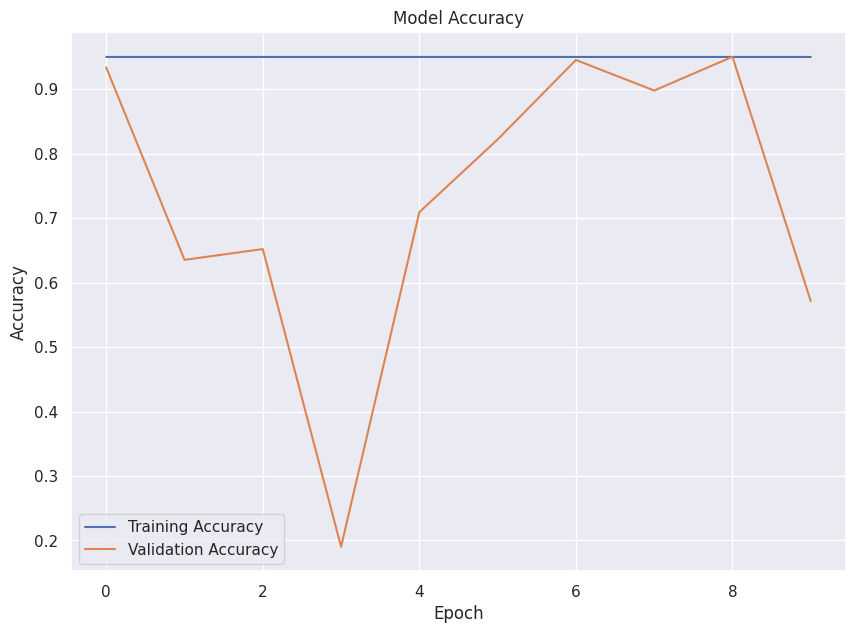

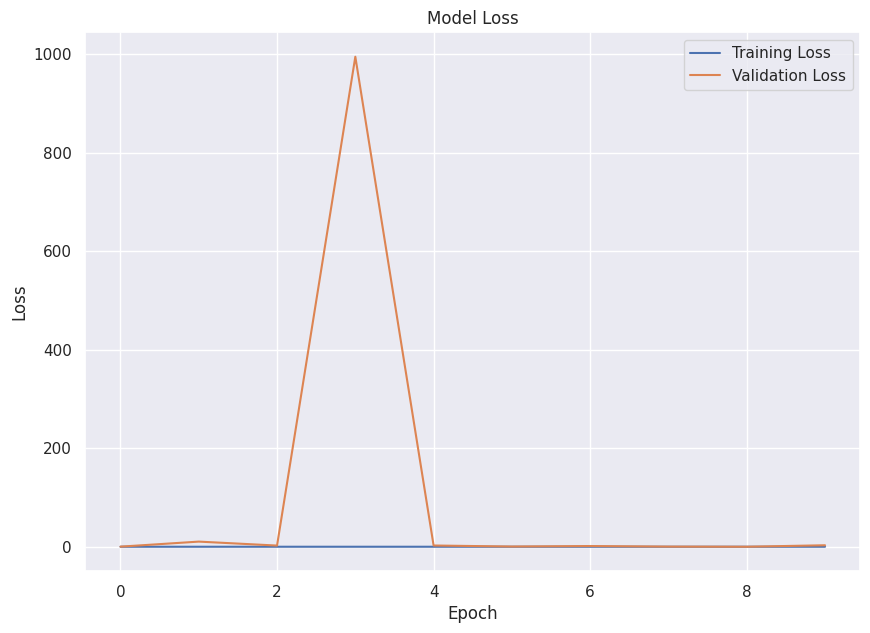

In [ ]:
import pickle
with open('/content/drive/MyDrive/nih_chest_xray_history.pkl', 'rb') as f:
    history = pickle.load(f)

import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history['binary_accuracy'], label='Training Accuracy')
plt.plot(history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
#plt.plot(history.history['loss'], label='Loss')
#plt.plot(history.history['binary_accuracy'], label='Binary Accuracy')
#plt.title("Training Progress")
#plt.xlabel("Epoch")
#plt.ylabel("Metric")
#plt.legend()
#plt.show()

**ROC Curve and AUROC** (Multiclass)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Step 1 – Predict probabilities for test set
# --------------------------
# y_test: shape (num_samples, num_classes) with 0/1 for each disease
# mlb: MultiLabelBinarizer object used during preprocessing (mlb.classes_ has disease names)

y_pred_probs = model.predict(X_test)  # Shape: (num_samples, num_classes)

# Sanity check shapes
print("y_test shape:", y_test.shape)
print("y_pred_probs shape:", y_pred_probs.shape)

# --------------------------
# Step 2 – Compute AUC for each label
# --------------------------
roc_auc_scores = {}
fpr_dict = {}
tpr_dict = {}

for i, label in enumerate(mlb.classes_):
    try:
        # Compute ROC only if the label exists in test set (avoid all 0s or all 1s)
        if len(np.unique(y_test[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
            fpr_dict[label] = fpr
            tpr_dict[label] = tpr
            roc_auc_scores[label] = auc(fpr, tpr)
        else:
            print(f"Skipping {label} (only one class present in y_test)")
    except Exception as e:
        print(f"Error processing {label}: {e}")

# --------------------------
# Step 3 – Select Top N labels by AUC
# --------------------------
top_n = 5  # Change as needed
top_labels = sorted(roc_auc_scores, key=roc_auc_scores.get, reverse=True)[:top_n]

print("\nTop labels by AUC:")
for label in top_labels:
    print(f"{label}: AUC = {roc_auc_scores[label]:.4f}")

# --------------------------
# Step 4 – Plot ROC curves
# --------------------------
plt.figure(figsize=(10, 7))

for label in top_labels:
    plt.plot(fpr_dict[label], tpr_dict[label],
             label=f'{label} (AUC = {roc_auc_scores[label]:.2f})')

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Top {top_n} Best Performing Labels')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


NameError: name 'X_test' is not defined

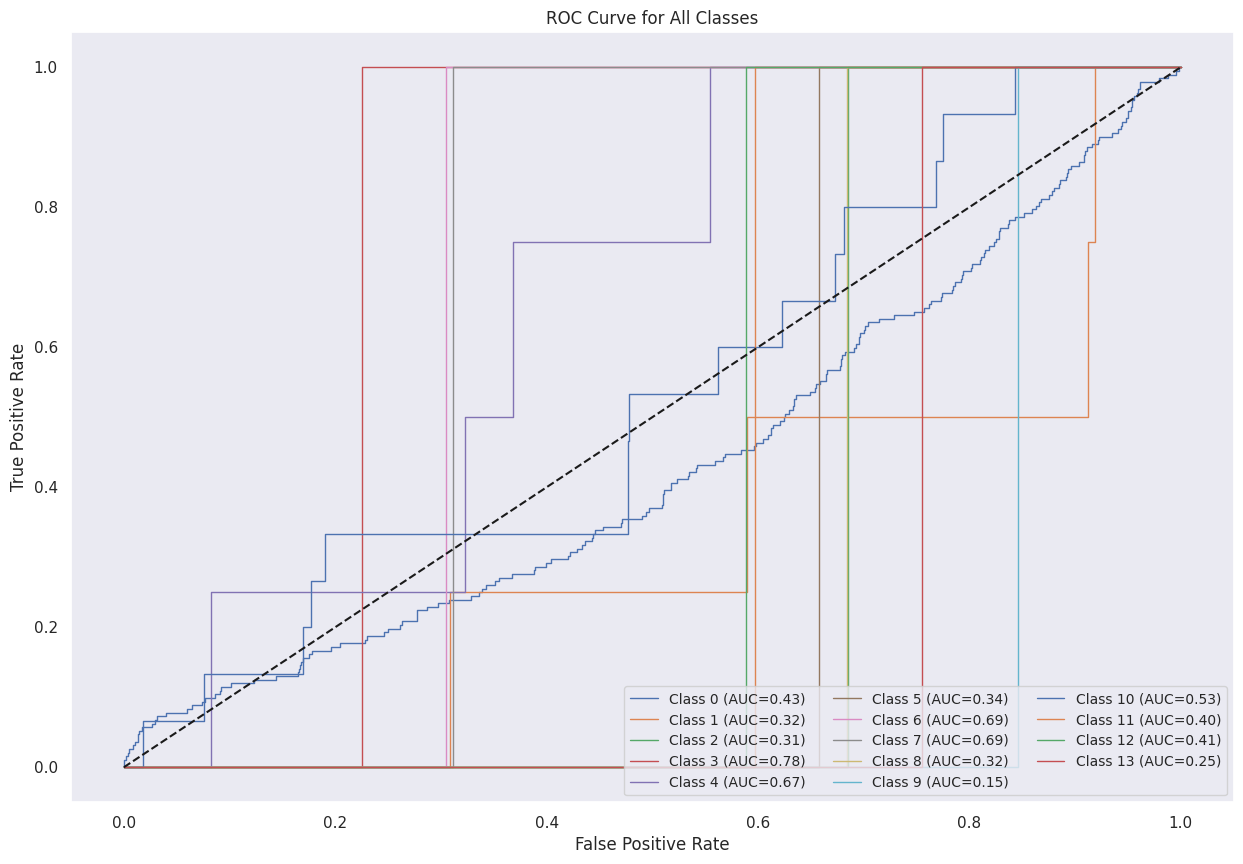

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"Class {i} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for All Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='small', ncol=3)
plt.grid()
plt.show()

In [ ]:
all_auc = list(roc_auc.values())
print("Macro-average AUC over all classes:", np.mean(all_auc))
print("Best AUC:", max(all_auc))
print("Worst AUC:", min(all_auc))

Macro-average AUC over all classes: 0.44980735750462264
Best AUC: 0.7750223015165031
Worst AUC: 0.15361284567350575


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/chest_xray_model.keras')

ValueError: File not found: filepath=/content/drive/MyDrive/chest_xray_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/sample_chest_xray_data/cleaned_metadata.csv')  # modify path if needed

In [ ]:
print(test_df.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Gender_Encoded', 'View_Encoded',
       'Is_Normal', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Num_Labels', 'Image Path'],
      dtype='object')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',  # modify if needed
    y_col=labels,        # this is your list of 14 disease labels
    target_size=(320, 320),
    batch_size=32,
    class_mode='raw',    # use 'raw' for multi-label classification
    shuffle=False
)

Found 5606 validated image filenames.


In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 135s 710ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# True and predicted labels
true_labels = test_generator.labels              # shape: (n_samples, 14)
predictions = model.predict(test_generator)      # shape: (n_samples, 14)

n_classes = true_labels.shape[1]                 # Should be 14 for Chest X-ray labels

# Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(16, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multilabel ROC Curve for Chest X-ray Findings")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid()
plt.show()

NameError: name 'test_generator' is not defined

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

preds = model.predict(valid_generator)
binary_preds = (preds > 0.5).astype(int)
true_labels = np.vstack([y for _, y in valid_generator])

print(classification_report(true_labels, binary_preds, target_names=labels))

27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


KeyboardInterrupt: 

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)
print("AUC per class:", auc_rocs)

In [ ]:
# Apply threshold to get binary predictions
binary_preds = (predicted_vals > 0.5).astype(int)

**F1, Precision, Recall per Label**

* **Macro:** Equal weight for each class

* **Micro:** Weighted by support (number of instances per class)

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# True labels
y_true = test_generator.labels

# Print full report
print(classification_report(y_true, binary_preds, target_names=labels, zero_division=0))

# OR just overall scores
macro_f1 = f1_score(y_true, binary_preds, average='macro')
micro_f1 = f1_score(y_true, binary_preds, average='micro')
macro_precision = precision_score(y_true, binary_preds, average='macro')
macro_recall = recall_score(y_true, binary_preds, average='macro')

print("Macro F1 score:", macro_f1)
print("Micro F1 score:", micro_f1)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)

**Plotting Confusion Matrix**

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

cm = multilabel_confusion_matrix(y_true, binary_preds)

for i in range(len(labels)):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {labels[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

**Interpreting Deep Learning Models**
------
Let's load in an X-ray image.



**GRAD CAM Implementation**

----------------------------------------

---



In [ ]:
import cv2

features, gradients = None, None

def forward_hook(module, inp, out):
    global features
    features = out

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# added here----
# After hooking gradients as before, compute Grad-CAM++ weights:
#grads_power_2 = gradients**2
#grads_power_3 = gradients**3
#sum_activations = features.sum(dim=(2,3), keepdim=True)
#alpha_num = grads_power_2
#alpha_den = 2*grads_power_2 + sum_activations * grads_power_3
#alphas = alpha_num / (alpha_den + 1e-7)
#weights = (alphas * F.relu(gradients)).sum(dim=(2,3), keepdim=True)
#cam = F.relu((weights * features).sum(1)).squeeze()
# ----------

def generate_gradcam(img_path, model, transform):
    model.eval()
    img = transform(Image.open(img_path).convert('L')).unsqueeze(0).to(device)
    outputs = model(img)
    pred = outputs.argmax(dim=1)
    model.zero_grad()
    outputs[0, pred].backward()

    grads_sq = gradients ** 2
    grads_cube = gradients ** 3
    sum_feats = features.sum(dim=(2,3), keepdim=True)

    alpha_num = grads_sq
    alpha_den = 2 * grads_sq + grads_cube * sum_feats
    alphas = alpha_num / (alpha_den + 1e-7)

    weights = (alphas * F.relu(gradients)).sum(dim=(2,3), keepdim=True)
    cam = (weights * features).sum(1).squeeze().cpu().relu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    heatmap = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
    orig = cv2.cvtColor(np.array(Image.open(img_path)), cv2.COLOR_RGB2BGR)
    return cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)

# Example usage:
heatmap_img = generate_gradcam('images/00000001_000.png', model, val_tf)
cv2.imwrite('gradcam_overlay.png', heatmap_img)

**Hyperparameter Tuning with Optuna**

In [ ]:
import optuna

def objective(trial):
    lr        = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    wd        = trial.suggest_loguniform('wd', 1e-6, 1e-3)
    gamma     = trial.suggest_uniform('gamma', 1.0, 3.0)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = FocalLoss(gamma=gamma)
    # Quick epoch for tuning
    train_one_epoch(model, train_loader, optimizer, criterion)
    auc, _ = validate(model, val_loader)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best trial:", study.best_trial.params)

**UPTO HERE-----------------------**

**-------------------------------PREVIOUS STARTS HERE**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation='sigmoid')(x)  # 15 diseases (multi-label)

model = Model(inputs=base_model.input, outputs=outputs)

from keras.metrics import AUC, Precision, Recall

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[AUC(), Precision(), Recall()])


In [ ]:
import tensorflow as tf
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        return -y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred) - \
               (1 - y_true) * (1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
    return loss_fn

**--------------------------**

In [ ]:
import torch.nn as nn
from torchvision import models

# Define the number of output classes (14 diseases + 'No Finding')
NUM_CLASSES = 15 # Ensure this matches your actual number of disease labels

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all parameters in the feature extractor part of the model
# for param in model.features.parameters():
#     param.requires_grad = False

# Modify the classifier head for your specific multi-label task
# VGG16's classifier is a sequential block. The last layer is usually an `nn.Linear` layer.
# We need to replace the last layer to match our NUM_CLASSES.
# The input features to the last layer are 4096 (from the previous Linear layer in VGG16).
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)

# No activation function (like Sigmoid) should be explicitly applied here if using BCEWithLogitsLoss,
# as BCEWithLogitsLoss handles the sigmoid internally for numerical stability.

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model moved to: {device}")
print(model) # Optional: Print model to confirm changes

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.9MB/s]


NameError: name 'torch' is not defined

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
import numpy as np
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps input image to activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
import matplotlib.pyplot as plt
import cv2

def display_gradcam(image_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply heatmap
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM Heatmap Overlay')
    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Replace this with the actual directory path where your images are stored
image_dir = "/content/sample_chest_xray_data/sample/sample/images"

# Assuming val_df exists and contains validation data and labels
# ✅ Define label columns based on model training
label_columns = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'No Finding'  # Remove this if not trained with it
]

# ✅ Check which columns are actually in val_df
existing_columns = val_df.columns.tolist()
missing = [col for col in label_columns if col not in existing_columns]
if missing:
    print("⚠️ Missing columns in val_df:", missing)

# ✅ Keep only label columns that are available
label_columns = [col for col in label_columns if col in val_df.columns]

# ✅ Convert labels to float
val_df[label_columns] = val_df[label_columns].fillna(0).astype('float32')

# ✅ Confirm shape
print("Validation labels shape:", val_df[label_columns].shape)

# Convert label columns to float (0.0 or 1.0)
#val_df[label_columns] = val_df[label_columns].fillna(0).astype('float32')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='Image Index',
    y_col=label_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',   # for multi-label classification
    shuffle=False
)


⚠️ Missing columns in val_df: ['No Finding']
Validation labels shape: (841, 14)
Found 841 validated image filenames.


In [ ]:
print(val_df.columns.tolist())

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y', 'Gender_Encoded', 'View_Encoded', 'Is_Normal', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Num_Labels', 'Image Path', 'labels_vector']


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, lr_reduce]
)

NameError: name 'train_generator' is not defined

In [ ]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        return -y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred) - \
               (1 - y_true) * (1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
    return loss

# Recompile model with focal loss (optional, use only if needed)
# model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluation
print("y_true shape:", y_true.shape)
print("y_pred_bin shape:", y_pred_bin.shape)
print("Label columns:", label_columns)

# ✅ Ensure predictions match labels
if y_pred_bin.shape[1] != len(label_columns):
    print(" Mismatch: predicted shape != label columns")
    # Optional: Auto-fix by trimming extra column
    min_dim = min(y_pred_bin.shape[1], len(label_columns))
    y_pred_bin = y_pred_bin[:, :min_dim]
    y_pred_probs = y_pred_probs[:, :min_dim]
    label_columns = label_columns[:min_dim]
    print("Trimmed predictions to match")

# Now print metrics
print("Classification Report (per class):")
print(classification_report(y_true, y_pred_bin, target_names=label_columns))

print("Macro Accuracy:", accuracy_score(y_true, y_pred_bin))
print("Macro Precision:", precision_score(y_true, y_pred_bin, average='macro'))
print("Macro Recall:", recall_score(y_true, y_pred_bin, average='macro'))
print("Macro F1 Score:", f1_score(y_true, y_pred_bin, average='macro'))
print("Macro ROC AUC:", roc_auc_score(y_true, y_pred_probs, average='macro'))


NameError: name 'y_true' is not defined